In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import itertools
import sys
sys.path.append('..')
from security_game.target import Target

from security_game.green_security_game import GreenSecurityGame
from security_game.infra_security_game import InfraSecurityGame

from solvers.mip import mip
from solvers.nash import nash
from solvers.double_oracle import double_oracle
from solvers.double_oracle_sf import double_oracle_sf
from solvers.no_regret import regret_matching
from solvers.simple_sse_lp import solve_sse_lp
from solvers.nfg_sse_lp import solve_general_sum_normal_form
import time
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

# GSG

In [4]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5
}

general_sum_kwargs = {
    "general_sum": True,
    "attacker_animal_value":  2350, 
    "defender_animal_value": 22966, 
    "defender_step_cost": 1.17, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)
river_line = [(2.2837, 16.16283352464626),(2.053, 16.066212728001727)]

In [9]:
gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=8, num_columns=8, escape_line_points=river_line)
gsg.generate(num_attackers=1, num_defenders=2, 
             home_base_assignments=[(kabo_djembe, bomassa, inner_post),(kabo_djembe, bomassa, inner_post)], 
             num_timesteps=8, 
             generate_utility_matrix=True, 
             defense_time_threshold=1, 
             generate_actions=False, 
             force_return=True,  
             **schedule_form_kwargs,**general_sum_kwargs)
# gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=8, num_rows=9, num_columns=9, escape_line_points=None)
# gsg.generate(num_attackers=1, num_defenders=2, 
#              home_base_assignments=[(kabo_djembe, bomassa, inner_post),(kabo_djembe, bomassa, inner_post)], 
#              num_timesteps=7, 
#              generate_utility_matrix=True, 
#              defense_time_threshold=1, 
#              generate_actions=False, 
#              force_return=True,  
#              **schedule_form_kwargs,**general_sum_kwargs)

{(1, 4): 0.7185929648241206, (5, 1): 0.22613065326633167, (6, 3): 0.36683417085427134, (0, 4): 0.5226130653266332, (6, 6): 0.24371859296482412, (3, 1): 0.2638190954773869, (4, 4): 0.5904522613065327, (2, 4): 0.6055276381909548, (5, 6): 0.12060301507537688, (4, 3): 0.3417085427135678, (0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (3, 0): 0, (3, 2): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (5, 0): 0, (5, 2): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0, (5, 7): 0, (6, 0): 0, (6, 1): 0, (6, 2): 0, (6, 4): 0, (6, 5): 0, (6, 7): 0, (7, 0): 0, (7, 1): 0, (7, 2): 0, (7, 3): 0, (7, 4): 0, (7, 5): 0, (7, 6): 0, (7, 7): 0}


In [8]:
gsg.schedule_form_dict["attacker_utility_matrix"]

array([[ 337.73869347,  531.40703518,  862.06030151, ..., 1422.98994975,
         283.41708543,  803.01507538],
       [ 337.73869347,  531.40703518,  862.06030151, ..., 1422.98994975,
         283.41708543,  803.01507538],
       [ 337.73869347,  531.40703518,  862.06030151, ...,  284.59798995,
         283.41708543,  803.01507538],
       ...,
       [1688.69346734,  531.40703518,  862.06030151, ..., 1422.98994975,
         283.41708543,  160.60301508],
       [1688.69346734,  531.40703518,  862.06030151, ..., 1422.98994975,
         283.41708543,  160.60301508],
       [1688.69346734,  531.40703518,  862.06030151, ..., 1422.98994975,
         283.41708543,  160.60301508]])

In [10]:
gsg.schedule_form_dict["attacker_utility_matrix"]

array([[ 374.71917262, 1062.81407035, 1557.66333787, ..., 1734.4523508 ,
         352.23572346, 1275.66634755],
       [ 374.71917262, 1062.81407035, 1557.66333787, ..., 1734.4523508 ,
         352.23572346, 1275.66634755],
       [ 374.71917262, 1062.81407035, 1557.66333787, ...,  346.89047016,
         352.23572346, 1275.66634755],
       ...,
       [1873.59586312, 1062.81407035, 1557.66333787, ..., 1734.4523508 ,
         352.23572346,  255.13326951],
       [1873.59586312, 1062.81407035, 1557.66333787, ..., 1734.4523508 ,
         352.23572346,  255.13326951],
       [1873.59586312, 1062.81407035, 1557.66333787, ..., 1734.4523508 ,
         352.23572346,  255.13326951]])

In [4]:
D_a, D_d, u_s, A_a, A_d, c, iteration_times, gaps = double_oracle_sf(gsg.schedule_form_dict,eps=1e-12, verbose=False)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2455389
Academic license 2455389 - for non-commercial use only - registered to jc___@columbia.edu


In [5]:
[(i,p) for i,p in enumerate(D_d) if p != 0], u_s

([(8, 0.6569496692890702),
  (9, 0.07100339474254017),
  (10, 0.01297102007559724),
  (12, 0.130262625176715),
  (13, 0.12881329071607742)],
 -87.0040886404324)

In [6]:
D_a, D_d, u = nash(gsg.schedule_form_dict["defender_utility_matrix"])

In [7]:
[(i,p) for i,p in enumerate(D_d) if p != 0],u

([(13, 0.07100339474253992),
  (77, 0.012971020075597417),
  (359, 0.12881329071607747),
  (542, 0.7857629600051474),
  (562, 0.0014493344606376635)],
 -87.00408864043239)

In [66]:
double_oracle(gsg,verbose=False)[2]

{0: 1.0, 1: 0.3146853146853147, 2: 0.5104895104895104, 3: 0.7272727272727273, 4: 0.33916083916083917, 5: 0.3671328671328671, 6: 0.8216783216783218, 7: 0.8426573426573427, 8: 0.1678321678321678, 9: 0.4755244755244755}


-0.4510556621880999

In [67]:
nash(gsg.utility_matrix)[2]

-0.4510556621880999

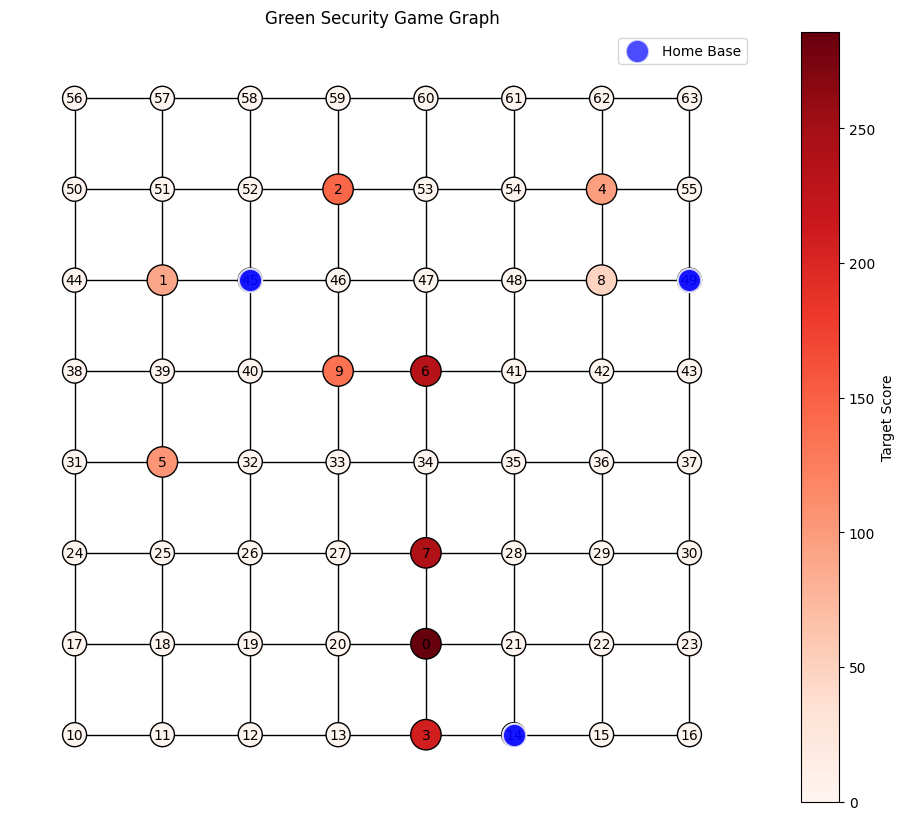

In [6]:
gsg.draw_graph()

In [12]:
gsg.defender_utility_matrix

array([[-0.70007405, -0.8043404 , -0.91977814, ..., -0.34258943,
        -0.08937116, -0.25321827],
       [-0.17383065, -0.27809699, -0.39353474, ..., -0.34884916,
        -0.09563089, -0.259478  ],
       [-0.70633378, -0.81060013, -0.53876286, ..., -0.34884916,
        -0.09563089, -0.259478  ],
       ...,
       [-0.71885324, -0.82311959, -0.93855733, ..., -0.36136862,
        -0.10815034, -0.27199746],
       [-0.71885324, -0.82311959, -0.93855733, ..., -0.36136862,
        -0.10815034, -0.27199746],
       [-0.71885324, -0.82311959, -0.93855733, ..., -0.36136862,
        -0.10815034, -0.27199746]])

In [15]:
gsg.defender_utility_matrix

array([[-0.71347249, -0.81973435, -0.9373814 , ..., -0.34914611,
        -0.09108159, -0.25806452],
       [-0.17077799, -0.27703985, -0.39468691, ..., -0.34914611,
        -0.09108159, -0.25806452],
       [-0.71347249, -0.81973435, -0.5426945 , ..., -0.34914611,
        -0.09108159, -0.25806452],
       ...,
       [-0.71347249, -0.81973435, -0.9373814 , ..., -0.34914611,
        -0.09108159, -0.25806452],
       [-0.71347249, -0.81973435, -0.9373814 , ..., -0.34914611,
        -0.09108159, -0.25806452],
       [-0.71347249, -0.81973435, -0.9373814 , ..., -0.34914611,
        -0.09108159, -0.25806452]])

In [28]:
gsg.schedule_form_dict["attacker_utility_matrix"]

array([[0.01954596, 0.03075414, 0.04989004, 0.07107622, 0.03314612,
        0.03587982, 0.08030246, 0.08235274, 0.01640221, 0.04647292],
       [0.01954596, 0.03075414, 0.04989004, 0.01421524, 0.03314612,
        0.03587982, 0.08030246, 0.08235274, 0.01640221, 0.04647292],
       [0.01954596, 0.03075414, 0.04989004, 0.01421524, 0.03314612,
        0.03587982, 0.08030246, 0.01647055, 0.01640221, 0.04647292],
       [0.01954596, 0.03075414, 0.04989004, 0.07107622, 0.03314612,
        0.03587982, 0.08030246, 0.01647055, 0.01640221, 0.04647292],
       [0.09772981, 0.03075414, 0.04989004, 0.01421524, 0.03314612,
        0.03587982, 0.08030246, 0.08235274, 0.01640221, 0.04647292],
       [0.09772981, 0.03075414, 0.04989004, 0.01421524, 0.03314612,
        0.03587982, 0.08030246, 0.01647055, 0.01640221, 0.04647292],
       [0.09772981, 0.03075414, 0.04989004, 0.07107622, 0.03314612,
        0.03587982, 0.08030246, 0.01647055, 0.01640221, 0.04647292],
       [0.09772981, 0.03075414, 0.0498900

In [30]:
gsg.schedule_form_dict["attacker_utility_matrix"]

array([[0.01954596, 0.06150827, 0.08744123, 0.0748442 , 0.04520994,
        0.06169054, 0.11395773, 0.10980618, 0.02008963, 0.07745629],
       [0.01954596, 0.06150827, 0.08744123, 0.01496884, 0.04520994,
        0.06169054, 0.11395773, 0.10980618, 0.02008963, 0.07745629],
       [0.01954596, 0.06150827, 0.08744123, 0.01496884, 0.04520994,
        0.06169054, 0.11395773, 0.02196124, 0.02008963, 0.07745629],
       [0.01954596, 0.06150827, 0.08744123, 0.0748442 , 0.04520994,
        0.06169054, 0.11395773, 0.02196124, 0.02008963, 0.07745629],
       [0.09772981, 0.06150827, 0.08744123, 0.01496884, 0.04520994,
        0.06169054, 0.11395773, 0.10980618, 0.02008963, 0.07745629],
       [0.09772981, 0.06150827, 0.08744123, 0.01496884, 0.04520994,
        0.06169054, 0.11395773, 0.02196124, 0.02008963, 0.07745629],
       [0.09772981, 0.06150827, 0.08744123, 0.0748442 , 0.04520994,
        0.06169054, 0.11395773, 0.02196124, 0.02008963, 0.07745629],
       [0.09772981, 0.06150827, 0.0874412

# ISG

In [2]:
gdf = gpd.read_file("chinatown_infra.geojson")

# Step 1: Handle relevant columns
infra_columns = [
    "id", "name", "power", "man_made", "amenity",
    "generator:method", "generator:source", "geometry"
]
available_columns = [col for col in infra_columns if col in gdf.columns]
gdf = gdf[available_columns].copy()

# Step 2: Extract generator type if present
gdf["generator_type"] = gdf.get("generator:method")
if "generator_type" not in gdf.columns or gdf["generator_type"].isnull().all():
    gdf["generator_type"] = gdf.get("generator:source")

# Step 3: Construct unified 'type' column
gdf["type"] = gdf.get("power")
if "amenity" in gdf.columns:
    gdf["type"] = gdf["type"].combine_first(gdf["amenity"])
if "man_made" in gdf.columns:
    gdf["type"] = gdf["type"].combine_first(gdf["man_made"])

# Step 4: Refine generator classification (solar vs. other)
gdf.loc[(gdf["type"] == "generator") & (gdf["generator_type"] == "photovoltaic"), "type"] = "solar_generator"
gdf.loc[(gdf["type"] == "generator") & (gdf["generator_type"] == "solar"), "type"] = "solar_generator"

# Step 5: Drop raw columns now that 'type' is finalized
df_simple = gdf[["id", "name", "type", "geometry"]].copy()

# Step 6: Separate nodes and ways
df_nodes = df_simple[df_simple["id"].str.contains("node")].copy()
df_nodes["x"] = df_nodes.geometry.x
df_nodes["y"] = df_nodes.geometry.y
df_nodes = df_nodes.drop(columns=["geometry"])

df_ways = df_simple[df_simple["id"].str.contains("way")].copy()
df_ways = df_ways.set_geometry("geometry").to_crs("EPSG:32618")
df_ways["centroid"] = df_ways.geometry.centroid
df_ways = df_ways.set_geometry("centroid").to_crs("EPSG:4326")
df_ways["x"] = df_ways.geometry.x
df_ways["y"] = df_ways.geometry.y
df_ways = df_ways.drop(columns=["geometry", "centroid"])

# Step 7: Combine nodes and ways
df_combined = pd.concat([df_nodes, df_ways], ignore_index=True)
df_combined = pd.concat([df_nodes, df_ways], ignore_index=True)
ny_blocks_gdf =  gpd.read_file("tl_2020_36_tabblock20.shp")
INFRA_WEIGHTS = {
    # Power Infrastructure
    "plant": 1.5,
    "generator": 1.35,
    "solar_generator": 0.95,
    "substation": 1.45,
    "transformer": 1.25,
    "tower": 1.1,
    "pole": 0.85,
    "line": 1.0,
    "minor_line": 0.9,
    "cable": 0.95,
    "switchgear": 1.2,
    "busbar": 0.8,
    "bay": 0.85,
    "converter": 1.05,
    "insulator": 0.75,
    "portal": 0.75,
    "connection": 0.7,
    "compensator": 1.0,
    "rectifier": 0.95,
    "inverter": 0.95,
    "storage": 0.9,

    # Healthcare
    "hospital": 1.5,
    "clinic": 1.35,

    # Education
    "school": 1.25,
    "university": 1.4,

    # Water & Sanitation
    "water_works": 1.45,
    "wastewater_plant": 1.4,

    # Government & Emergency Services
    "fire_station": 1.3,
    "police": 1.4,
    "courthouse": 1.2,

    # Critical Infrastructure
    "bunker_silo": 1.0,

    # Communications
    "communications_tower": 1.25,
}


In [26]:
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

brooklyn_bridge = (40.712438951145266, -74.004937098962)

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5
}

general_sum_kwargs = {
    "general_sum": True,
    "attacker_feature_value":  1, 
    "defender_feature_value": 100, 
    "defender_step_cost": 0,
    "alpha":.5
}



isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large, escape_point=brooklyn_bridge)
isg.generate(num_attackers=1, num_defenders=1,
             home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza)],
             num_timesteps=7, 
             generate_utility_matrix=True, 
             generate_actions=False, 
             force_return=True, 
             defense_time_threshold=1, 
             **general_sum_kwargs, 
             **schedule_form_kwargs)

C:\Users\Noah\GameGenerators\notebooks\..\security_game\infra_security_game.py:67: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  self.graph = ox.graph_from_bbox(north, south, east, west, network_type="drive")
C:\Users\Noah\GameGenerators\notebooks\..\security_game\infra_security_game.py:67: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  self.graph = ox.graph_from_bbox(north, south, east, west, network_type="drive")


In [7]:
isg.schedule_form_dict["defender_utility_matrix"]

array([[-0.53242706, -0.68112034, -0.34019582, ..., -0.49974937,
        -0.49974937, -0.84542244],
       [-0.53242706, -0.68112034, -0.34019582, ..., -0.49974937,
        -0.49974937, -0.84542244],
       [-0.53242706, -0.68112034, -0.34019582, ..., -0.49974937,
        -0.49974937, -0.84542244],
       ...,
       [-0.32624777, -0.47494106, -0.13401653, ..., -0.29357008,
        -0.29357008, -0.63924315],
       [-0.42933741, -0.5780307 , -0.23710618, ..., -0.39665972,
        -0.39665972, -0.31340999],
       [-0.32624777, -0.47494106, -0.13401653, ..., -0.29357008,
        -0.29357008, -0.21032034]])

In [11]:
isg.schedule_form_dict["defender_utility_matrix"]

array([[-0.22315813, -0.37185142, -0.03092689, ..., -0.19048044,
        -0.19048044, -0.53615351],
       [-0.22315813, -0.37185142, -0.03092689, ..., -0.19048044,
        -0.19048044, -0.53615351],
       [-0.22315813, -0.37185142, -0.03092689, ..., -0.19048044,
        -0.19048044, -0.53615351],
       ...,
       [-0.22315813, -0.37185142, -0.03092689, ..., -0.19048044,
        -0.19048044, -0.53615351],
       [-0.22315813, -0.37185142, -0.03092689, ..., -0.19048044,
        -0.19048044, -0.1072307 ],
       [-0.22315813, -0.37185142, -0.03092689, ..., -0.19048044,
        -0.19048044, -0.1072307 ]])

In [18]:
isg.schedule_form_dict["attacker_utility_matrix"]

array([[0.41130636, 0.68487569, 0.0556982 , ..., 0.35289378, 0.35260676,
        1.        ],
       [0.41130636, 0.68487569, 0.0556982 , ..., 0.35289378, 0.35260676,
        1.        ],
       [0.41130636, 0.68487569, 0.0556982 , ..., 0.35289378, 0.35260676,
        1.        ],
       ...,
       [0.41130636, 0.68487569, 0.0556982 , ..., 0.35289378, 0.35260676,
        1.        ],
       [0.41130636, 0.68487569, 0.0556982 , ..., 0.35289378, 0.35260676,
        0.2       ],
       [0.41130636, 0.68487569, 0.0556982 , ..., 0.35289378, 0.35260676,
        0.2       ]])

In [20]:
isg.schedule_form_dict["attacker_utility_matrix"]

array([[0.41622059, 0.693554  , 0.05768291, ..., 0.35527221, 0.35527221,
        1.        ],
       [0.41622059, 0.693554  , 0.05768291, ..., 0.35527221, 0.35527221,
        1.        ],
       [0.41622059, 0.693554  , 0.05768291, ..., 0.35527221, 0.35527221,
        1.        ],
       ...,
       [0.41622059, 0.693554  , 0.05768291, ..., 0.35527221, 0.35527221,
        1.        ],
       [0.41622059, 0.693554  , 0.05768291, ..., 0.35527221, 0.35527221,
        0.2       ],
       [0.41622059, 0.693554  , 0.05768291, ..., 0.35527221, 0.35527221,
        0.2       ]])

In [25]:
isg.schedule_form_dict["attacker_utility_matrix"]

array([[0.38043308, 0.63035487, 0.04322942, ..., 0.33795151, 0.33586127,
        1.        ],
       [0.38043308, 0.63035487, 0.04322942, ..., 0.33795151, 0.33586127,
        1.        ],
       [0.38043308, 0.63035487, 0.04322942, ..., 0.33795151, 0.33586127,
        1.        ],
       ...,
       [0.38043308, 0.63035487, 0.04322942, ..., 0.33795151, 0.33586127,
        1.        ],
       [0.38043308, 0.63035487, 0.04322942, ..., 0.33795151, 0.33586127,
        0.2       ],
       [0.38043308, 0.63035487, 0.04322942, ..., 0.33795151, 0.33586127,
        0.2       ]])

In [16]:
best_t, coverage, du = solve_general_sum_normal_form(isg.schedule_form_dict["defender_utility_matrix"], isg.schedule_form_dict["attacker_utility_matrix"])

In [17]:
sum([1 for i,p in coverage.items() if p > 0])

3

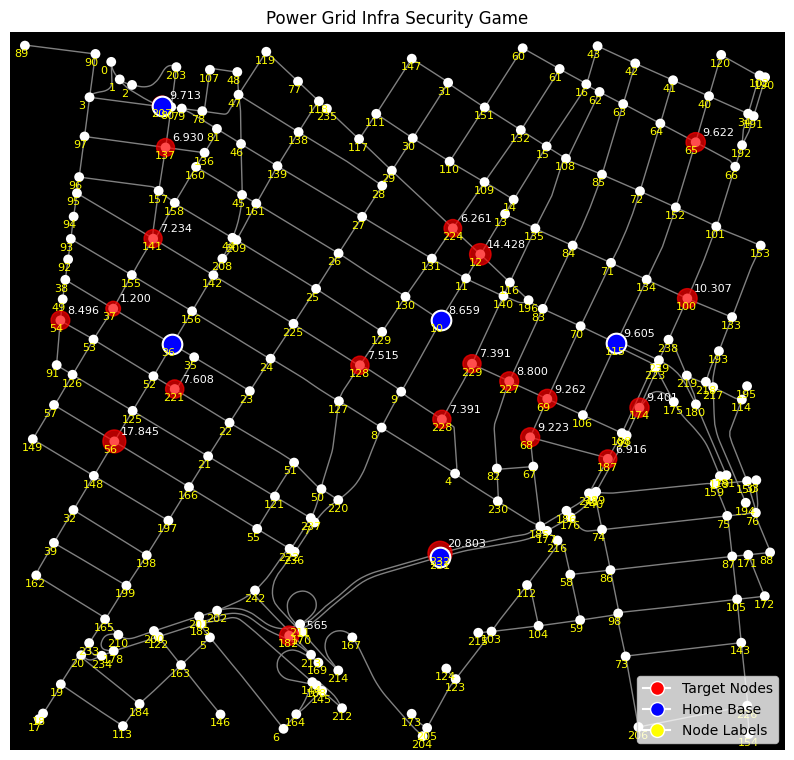

In [19]:
isg.draw_graph()

In [4]:
double_oracle(isg,eps=1e-12, verbose=False)[2]

{10: 8.658799344785894, 12: 14.428274639004949, 37: 1.2, 54: 8.495961513378065, 56: 17.844828434921894, 65: 9.622492355745342, 68: 9.223032729564483, 69: 9.262061401678919, 100: 10.306755033113276, 115: 9.605100712852211, 128: 7.5152282266858625, 137: 6.92995334237223, 141: 7.234026867518198, 174: 9.400832113884903, 182: 9.564635468196924, 187: 6.91574936644157, 207: 9.712550687115396, 221: 7.607639343095502, 224: 6.260741315630621, 227: 8.800318389096768, 228: 7.390866359057434, 229: 7.390866359057434, 232: 20.803390275767253}
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2455389
Academic license 2455389 - for non-commercial use only - registered to jc___@columbia.edu


-11.532955276441761

In [5]:
nash(isg.utility_matrix)[2]

TypeError: object of type 'NoneType' has no len()

In [16]:
double_oracle_sf(isg.schedule_form_dict)[2]

running...
 U(D_d, BR A): -20.803390275767253, U(D_a, BR D): -1.731759868957179
Current Gap: 19.071630406810073
 U(D_d, BR A): -20.803390275767253, U(D_a, BR D): -4.160678055153451
Current Gap: 16.642712220613802
 U(D_d, BR A): -17.844828434921894, U(D_a, BR D): -2.4456075316747867
Current Gap: 15.399220903247107
 U(D_d, BR A): -17.844828434921894, U(D_a, BR D): -3.5689656869843787
Current Gap: 14.275862747937515
 U(D_d, BR A): -11.526521305876853, U(D_a, BR D): -3.8421737686256185
Current Gap: 7.684347537251234
 U(D_d, BR A): -11.657426870842508, U(D_a, BR D): -2.3319794564640084
Current Gap: 9.3254474143785
 U(D_d, BR A): -10.306755033113276, U(D_a, BR D): -8.07306869350923
Current Gap: 2.2336863396040467
 U(D_d, BR A): -10.306755033113276, U(D_a, BR D): -2.0613510066226555
Current Gap: 8.245404026490622
 U(D_d, BR A): -9.712550687115396, U(D_a, BR D): -7.075531044345877
Current Gap: 2.637019642769519
 U(D_d, BR A): -9.712550687115396, U(D_a, BR D): -1.942510137423079
Current Gap: 7.

-9.105531443212156

In [17]:
nash(isg.schedule_form_dict["defender_utility_matrix"])[2]

-9.105531443212158

In [13]:
isg.schedule_form_dict["attacker_utility_matrix"]

array([[0.36124549, 0.59647043, 0.03548013, ..., 0.32866495, 0.32545403,
        1.        ],
       [0.36124549, 0.59647043, 0.03548013, ..., 0.32866495, 0.32545403,
        1.        ],
       [0.36124549, 0.59647043, 0.03548013, ..., 0.32866495, 0.32545403,
        1.        ],
       ...,
       [0.36124549, 0.59647043, 0.03548013, ..., 0.32866495, 0.32545403,
        1.        ],
       [0.36124549, 0.59647043, 0.03548013, ..., 0.32866495, 0.32545403,
        0.2       ],
       [0.36124549, 0.59647043, 0.03548013, ..., 0.32866495, 0.32545403,
        0.2       ]])

In [14]:
isg.schedule_form_dict["defender_utility_matrix"]

array([[-0.13583538, -0.22634434, -0.01882507, ..., -0.11594462,
        -0.11594462, -0.32635431],
       [-0.13583538, -0.22634434, -0.01882507, ..., -0.11594462,
        -0.11594462, -0.32635431],
       [-0.13583538, -0.22634434, -0.01882507, ..., -0.11594462,
        -0.11594462, -0.32635431],
       ...,
       [-0.13583538, -0.22634434, -0.01882507, ..., -0.11594462,
        -0.11594462, -0.32635431],
       [-0.13583538, -0.22634434, -0.01882507, ..., -0.11594462,
        -0.11594462, -0.06527086],
       [-0.13583538, -0.22634434, -0.01882507, ..., -0.11594462,
        -0.11594462, -0.06527086]])

In [16]:
isg.schedule_form_dict["defender_utility_matrix"]

array([[-0.41622059, -0.693554  , -0.05768291, ..., -0.35527221,
        -0.35527221, -1.        ],
       [-0.41622059, -0.693554  , -0.05768291, ..., -0.35527221,
        -0.35527221, -1.        ],
       [-0.41622059, -0.693554  , -0.05768291, ..., -0.35527221,
        -0.35527221, -1.        ],
       ...,
       [-0.41622059, -0.693554  , -0.05768291, ..., -0.35527221,
        -0.35527221, -1.        ],
       [-0.41622059, -0.693554  , -0.05768291, ..., -0.35527221,
        -0.35527221, -0.2       ],
       [-0.41622059, -0.693554  , -0.05768291, ..., -0.35527221,
        -0.35527221, -0.2       ]])